### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.


### Часть 1. Анализ текстов
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [34]:
import json

import bz2
# import regex
# from scipy import sparse
from transliterate import translit

In [35]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm.auto import tqdm
tqdm.pandas(desc="progress: ")

In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        # responses.append(resp)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
df_responses_raw = pd.DataFrame(responses)
# df_responses_raw = pd.read_json('banki_responses.json.bz2', compression='bz2', lines=True)

201030it [01:36, 2090.33it/s]


In [7]:
df_responses_raw.sample()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
60987,г. Санкт-Петербург,False,"Не списывает деньги по кредиту вовремя, а пото...",2,лицензия № 1481,Anna111,Сбербанк России,2014-01-16 12:19:00,Я три года (в 2010 году) назад в сбербанке офо...,1.0


# Часть 1
## 1. Посчитайте количество отзывов в разных городах и на разные банки

In [8]:
# Много различных преобразований и фильтров
df_responses = df_responses_raw.copy()
df_responses.dropna(subset=['city'], inplace=True)
df_responses['city'] = df_responses['city'].str.lower()
# df_responses['city'] = df_responses['city'].str.replace('[\W]+', ' ', regex=True)
df_responses['city'] = df_responses['city'].str.replace(
    '[.,\(\)\|\?]+', ' ', regex=True)
# df_responses['city'] = df_responses['city'].str.replace([!#$%( ) * + , \ -. / : ; < = > ? @ [ ] ^ _ ` { | }]+', ' ', regex=True)

df_responses['city'] = df_responses['city'].str.strip()

# df_responses['len_city] = df_responses[~(df_responses['city'].str.len() > 20)]
df_responses['city'] = df_responses['city'].str.replace(
    '(г )', '', regex=True)
df_responses = df_responses[~(df_responses['city'].str.len() > 20)]
df_responses = df_responses[~(df_responses['city'].str.len() < 3)]
df_responses = df_responses[~(
    df_responses['city'].str.isdigit().fillna(False))]
df_responses = df_responses[~(
    df_responses['city'].str.contains('[\d]{7,}', na=False))]

df_responses['city'] = df_responses['city'].str.replace(
    '(хх)', 'х', regex=True)
df_responses['city'] = df_responses['city'].str.replace(
    '(кх)', 'х', regex=True)

df_responses['city'] = df_responses['city'].str.replace(
    '[\s]+', ' ', regex=True)

df_responses['city'] = df_responses['city'].apply(
    lambda row: translit(row, 'ru'))

df_responses['city'] = df_responses['city'].str.strip()
df_responses['city'] = df_responses['city'].str.capitalize()

list_city = pd.Series(df_responses['city'].unique())  # .sort_values()
list_city

0                 Москва
1            Новосибирск
2             Ставрополь
3              Челябинск
4              Волгоград
              ...       
2972        Оренбур орск
2973                Ектб
2974    Владимирская обл
2975              Вся рф
2976     Москва-владимир
Length: 2977, dtype: object

### Импортирую спец библиотеки и пишу обертку

In [9]:
from pullenti_wrapper.referent import Referent
from pullenti_wrapper.processor import Processor, GEO, ADDRESS
from pullenti_wrapper.langs import set_langs, RU
from natasha import AddrExtractor, MorphVocab, Doc, Segmenter
segmenter = Segmenter()
morph_vocab = MorphVocab()
addr_extractor = AddrExtractor(morph_vocab)

# pip install pullenti-wrapper
set_langs([RU])
processor = Processor([GEO, ADDRESS])


def extract_city_name(text, method='pullenti'):
    if method == 'pullenti':
        result = processor(text).matches
        if result:
            try:
                # Создаю список городОв первое совпадение по типу город 'Москва Рязань' -> 'москва'
                name = [
                    i.referent.name for i in result if i.referent.type == 'город']
                if name:
                    # Достаю первое совпадение по типу город 'Москва Рязань' -> 'москва'
                    return name[0].lower()
            except AttributeError:
                print(text)
                return '?'

    if method == 'natasha':
        name = [i.fact for i in addr_extractor(text) if i.fact.type == None]
        if name:
            return name[0].value.lower()

    return '?'
# extract_city_name(text)

In [10]:
print(pd.Timestamp.now())
# функцию вызываю раздельно в два этапа, т.к. скорость выполнения различных методов разная, и остаток уже выполняю на более медленной
df_responses['city_name'] = df_responses['city'].progress_apply(
    extract_city_name, args=('pullenti',))
df_responses.loc[df_responses['city_name'] == '?', 'city_name'] = df_responses.loc[df_responses['city_name']
                                                                                   == '?', 'city'].progress_apply(extract_city_name, args=('natasha',))
print(pd.Timestamp.now())

2022-11-12 08:33:21.888447


progress:  78%|███████▊  | 105588/135426 [02:48<00:47, 631.63it/s]

Мо городок 17


progress:  97%|█████████▋| 131602/135426 [03:28<00:05, 649.76it/s]

Зеленоград корп1824


progress: 100%|██████████| 16397/16397 [01:10<00:00, 232.49it/s]

2022-11-12 08:38:07.241180


In [4]:
df_responses = pd.read_csv('df_responses.zip')
df_responses.sample(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_name
6638,Новокузнецк,False,Звонки из-за просрочки,1,лицензия № 2289,novkuzr.88,Русский Стандарт,2015-04-06 10:36:42,Являюсь заемщиком банка Русский Стандарт. У ме...,NaN,новокузнецк
71470,Петербург,False,Угораздила мужа перевести деньги мне через Кив...,4,лицензия № 2241,Azirius,Киви Банк,2013-09-23 10:17:00,"В итоге ""Ограничение на исходящие платежи"" и н...",1.0,санкт-петербург
107106,Москва,False,Автокредитование,2,лицензия № 1978,Pauers,Московский Кредитный Банк,2012-04-18 15:11:00,Добрый день! Решил поделиться своей историей. ...,5.0,москва


In [5]:
# dict_replace = {"Питер":'санкт-петербург', 'Мосцоw':'москва', 'Санк-петербург':'санкт-петербург', 'С петербург':'санкт-петербург'}
# df_responses['city'].replace(dict_replace, inplace=True)
# df_responses.loc[df_responses['city_name'] == '?', 'city_name'] = df_responses.loc[df_responses['city_name'] == '?', 'city'].progress_apply(extract_city_name, args=('pullenti',))
# v.loc[df_responses['city_name'] == '?', 'city_name'] = df_responses.loc[df_responses['city_name'] == '?', 'city'].progress_apply(extract_city_name, args=('natasha',))
print('Необработано строк: ',
      df_responses.loc[df_responses['city_name'] == '?'].shape[0])
print('Необработанный "города":')
other_name = df_responses.loc[df_responses['city_name'] ==
                              '?', 'city'].value_counts(ascending=False, dropna=False)
other_name.rename_axis('city_other', inplace=True)

other_name = other_name.reset_index()
other_name

Необработано строк:  6537
Необработанный "города":


,city_other,city
0,Россия,206
1,Щелково,192
2,Железнодорожный,186
3,Ивантеевка,87
4,Дмитров,81
...,...,...
1778,Рязантдк,1
1779,Лазаревское,1
1780,Нюрнберг,1
1781,Миск,1


In [6]:
print("Количество отзывов по городам:")
df_responses['city_name'].value_counts()

Количество отзывов по городам:


москва             57164
санкт-петербург    15639
?                   6537
новосибирск         2388
екатеринбург        2380
                   ...  
нгевинномысск          1
соновоборск            1
великй новгород        1
волоград               1
свияжск                1
Name: city_name, Length: 537, dtype: int64

In [7]:
# Анализ уникальных значений, показывает, что названия банков - нормальные
pd.Series(df_responses['bank_name'].unique()).sort_values()

329          2Т Банк
541        АБ Финанс
327              АББ
508         АМБ Банк
542         АМТ Банк
           ...      
372       Юникорбанк
219         Юнистрим
191          ЯР-Банк
59     Яндекс.Деньги
196        Ярославич
Length: 591, dtype: object

In [8]:
print("Количество отзывов по банкам:")
df_responses['bank_name'].value_counts()

Количество отзывов по банкам:


Сбербанк России                     24580
Альфа-Банк                           8955
ВТБ 24                               7165
Хоум Кредит Банк                     7152
Русский Стандарт                     7100
                                    ...  
Кузнецкий                               1
Развитие                                1
Новый Символ                            1
Новокузнецкий Муниципальный Банк        1
Нижегородпромстройбанк                  1
Name: bank_name, Length: 591, dtype: int64

### 2. Постройте гистограмы длин слов в символах и в словах
##### Не очень я понял вторую часть "построить гистограмму длин слов в словах" ????
##### Как я понимаю нужно построить нормальное распределение длин слов

In [9]:
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns

punctuation = punctuation + '``' + "''" + '...'

In [10]:
print(pd.Timestamp.now())
corpus = [token.lower() for msg in df_responses['text'] for token in word_tokenize(msg, language="russian") if token not in punctuation]
freq_dict = Counter(corpus)
print(pd.Timestamp.now())

2022-11-15 14:49:47.734522
2022-11-15 14:53:42.652606


<AxesSubplot: xlabel='len'>

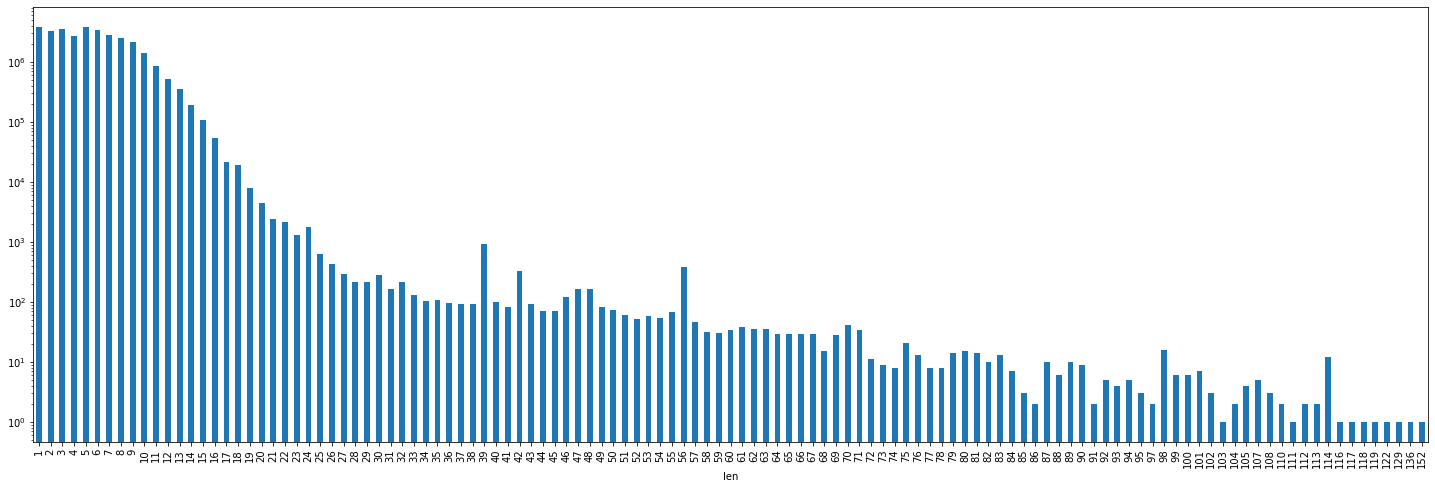

In [28]:
df_word_len = pd.Series(freq_dict).to_frame().reset_index().rename(columns={'index':'word', 0:'count'})
df_word_len['len'] = df_word_len['word'].str.len()
df_word_len = df_word_len[~df_word_len['word'].str.isdecimal()]
df_hist = df_word_len.groupby('len')['count'].sum()
df_hist.plot(kind = 'bar', figsize=(25,8), logy=True)

#### Выше построил гистограмму длин слов в символах, для этого вручную общитал частотный словарь и подготовил готовые данные для столбачтой диаграммы, чтобы получить гистограмму, а делал это т.к. напрямую передать сырые данные .plot(kind='hist') оч долго думало и безрезультативно, не построил гистограмму длин слов в словах, не оч понимаю, это что на оси Х должны быть все(400к) уникальные слова??

3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

In [36]:
# 10 самых частых слов
freq_dict.most_common(10)

[('в', 1177773),
 ('и', 937682),
 ('не', 760761),
 ('на', 627982),
 ('что', 555479),
 ('я', 514090),
 ('с', 406585),
 ('по', 328917),
 ('мне', 288373),
 ('банка', 239613)]

In [47]:
from nltk.corpus import stopwords as SW
stopwords = SW.words("russian")

tokens_wo_se = [tok for tok in corpus if tok not in stopwords and len(tok) > 2]

In [51]:
# 10 самых частых слов без стоп слов
freq_dict_wo_sw = Counter(tokens_wo_se)
freq_dict_wo_sw.most_common(10)


[('банка', 239613),
 ('банк', 176835),
 ('это', 161613),
 ('деньги', 116237),
 ('карту', 95045),
 ('карты', 92537),
 ('кредит', 70331),
 ('день', 68399),
 ('заявление', 63626),
 ('отделение', 59338)]

In [56]:
is_noun = lambda pos: pos[:2] == 'NN'
tokens_nouns = [word for (word, pos) in nltk.pos_tag(tokens_wo_se) if is_noun(pos)] 

In [58]:
# 10 самых частых существительных
freq_dict_nouns = Counter(tokens_nouns)
freq_dict_nouns.most_common(10)

[('банка', 236706),
 ('банк', 174951),
 ('это', 160182),
 ('деньги', 115159),
 ('карту', 93554),
 ('карты', 90721),
 ('кредит', 68094),
 ('день', 65621),
 ('заявление', 62866),
 ('отделение', 57957)]

nltk не очень хорошо определяет имена существительные, возможно другие методы или комбинация методов, будет лучше, но сейчас я его не буду реализовывать

In [66]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
corpus_lemm = [lemmatizer.lemmatize(token) for token in corpus]

In [67]:
# 10 самых частых лемм
freq_dict_lemm = Counter(corpus_lemm)
freq_dict_lemm.most_common(10)

[('в', 1177773),
 ('и', 937682),
 ('не', 760761),
 ('на', 627982),
 ('что', 555479),
 ('я', 514090),
 ('с', 406585),
 ('по', 328917),
 ('мне', 288373),
 ('банка', 239613)]

## Классификация текстов

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

# from sklearn.manifold import TSNE
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import Normalizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])


clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])

ModuleNotFoundError: No module named 'sklearn'